**References**



*   https://github.com/rizkiarm/LipNet
*   https://github.com/osalinasv/lipnet



*   https://github.com/xinshuoweng/mylipnet

*   List item





In [1]:
!pip install sk-video
!pip install dlib
!pip install mtcnn
from google.colab import drive
drive.mount('/content/drive')
!pip install Pillow
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 2.3MB 4.8MB/s 
     |████████████████████████████████| 2.3MB 5.0MB/s 
     |████████████████████████████████| 28.3MB 85kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import skvideo.io
import cv2
import os
from keras import backend as K
from scipy import ndimage
import imageio
import skimage
from google.colab.patches import cv2_imshow
from mtcnn.mtcnn import MTCNN
from skimage import io
import tensorflow as tf
import re
import string
from collections import Counter
from keras.layers.convolutional import Conv3D, ZeroPadding3D
from keras.layers.pooling import MaxPooling3D
from keras.layers.core import Dense, Activation, SpatialDropout3D, Flatten,Lambda
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, CSVLogger, ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from keras import backend as K
import keras
import pickle
import glob
import datetime
import sys
from nltk.translate import bleu_score
import editdistance
import csv
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

Using TensorFlow backend.


# Video preprocessing and converting it into frames

In [0]:
class Video(object):
    def __init__(self, vtype='mouth'):
        self.vtype = vtype

    def from_frames(self, path):
        frames_path = sorted([os.path.join(path, x) for x in os.listdir(path)])
        frames = [imageio.imread(frame_path) for frame_path in frames_path]
        self.handle_type(frames)
        return self

    def from_video(self, path):
        frames = self.get_video_frames(path)
        self.handle_type(frames)
        return self

    def from_array(self, frames):
        self.handle_type(frames)
        return self

    def handle_type(self, frames):
        if self.vtype == 'mouth':
            self.process_frames_mouth(frames)
        elif self.vtype == 'face':
            self.process_frames_face(frames)
        else:
            raise Exception('Video type not found')

    def process_frames_face(self, frames):
        predictor = ''
        detector = MTCNN()
        mouth_frames = self.get_frames_mouth(detector, predictor, frames)
        self.face = np.array(frames)
        self.mouth = np.array(mouth_frames)
        self.set_data(mouth_frames)

    def process_frames_mouth(self, frames):
        self.face = np.array(frames)
        self.mouth = np.array(frames)
        self.set_data(frames)

    def get_frames_mouth(self, detector, predictor, frames):
        MOUTH_WIDTH = 100
        MOUTH_HEIGHT = 50
        HORIZONTAL_PAD = 0.19
        normalize_ratio = None
        mouth_frames = []
        for frame in frames:
            dets = detector.detect_faces(frame)
            mouth_points = []
            if dets and dets[0]['keypoints'] and dets[0]['keypoints']['mouth_left']:
              x = dets[0]['keypoints']['mouth_left'][0]
              y = dets[0]['keypoints']['mouth_left'][1]
              mouth_points.append((x,y))
            else:
              continue
            if dets and dets[0]['keypoints'] and dets[0]['keypoints']['mouth_right']:
              x1 = dets[0]['keypoints']['mouth_right'][0]
              y1 = dets[0]['keypoints']['mouth_right'][1]
              mouth_points.append((x1,y1))
                      
            np_mouth_points = np.array(mouth_points)
            mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

            if normalize_ratio is None:
                mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
                mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

                normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

            new_img_shape = (int(frame.shape[0] * normalize_ratio), int(frame.shape[1] * normalize_ratio))
            resized_img = skimage.transform.resize(frame, new_img_shape)

            mouth_centroid_norm = mouth_centroid * normalize_ratio

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]
            mouth_frames.append(mouth_crop_image)
        return mouth_frames

    def get_video_frames(self, path):
        videogen = skvideo.io.vreader(path)
        frames = np.array([frame for frame in videogen])
        return frames

    def set_data(self, frames):
        data_frames = []
        for frame in frames:
            frame = frame.swapaxes(0,1) 
            if len(frame.shape) < 3:
                frame = np.array([frame]).swapaxes(0,2).swapaxes(0,1) 
            data_frames.append(frame)
        frames_n = len(data_frames)
        data_frames = np.array(data_frames) 
        if K.image_data_format() == 'channels_first':
            data_frames = np.rollaxis(data_frames, 3) 
        self.data = data_frames
        self.length = frames_n

# Saving videos into frames

In [4]:
def mkdir_p(path):
  try:
    tf.gfile.MkDir(path)
  except tf.errors.OpError as e:
    if os.path.isdir(path):
      pass
    else:
      raise

def find_files(directory, pattern):
    filename = []
    for root, dirs, files in os.walk(directory):
        for basename in files:
            filename.append(os.path.join(root, basename))
    return filename

videos_generic_folder_path = "/content/drive/My Drive/GRID/s"
images_generic_folder_path = "/content/drive/My Drive/GRID/images/mtcnn/s"

for i in range(1,2):
  curr_video_folder_path = videos_generic_folder_path + str(i+1) + "_samples"
  curr_image_folder_path = images_generic_folder_path + str(i+1)
  mkdir_p(curr_image_folder_path)

  ii = 0
  for filepath in find_files(curr_video_folder_path, ".mpg"):
    file_name = filepath.split('/')
    if file_name:
      file_name = file_name[6]
      file_name = file_name.replace(".mpg", "")
    mkdir_p(curr_image_folder_path + "/" + file_name)
    video = Video(vtype='face').from_video(filepath)
    for frame in video.mouth:
      io.imsave(os.path.join(curr_image_folder_path + "/" + file_name + "/", "mouth_{0:03d}.png".format(ii)), frame)
      ii += 1

# Connectionist Temporal Classification(CTC) loss

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def CTC(name, args):
	return Lambda(ctc_lambda_func, output_shape=(1,), name=name)(args)

def _decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    """Decodes the output of a softmax.
    Can use either greedy search (also known as best path) or a constrained dictionary search.
    # Arguments
        y_pred: tensor `(samples, time_steps, num_categories)`
            containing the prediction, or output of the softmax.
        input_length: tensor `(samples, )` containing the sequence length for
            each batch item in `y_pred`.
        greedy: perform much faster best-path search if `true`.
            This does not use a dictionary.
        beam_width: if `greedy` is `false`: a beam search decoder will be used
            with a beam of this width.
        top_paths: if `greedy` is `false`, how many of the most probable paths will be returned.
    # Returns
        Tuple:
            List: if `greedy` is `true`, returns a list of one element that
                contains the decoded sequence.
                If `false`, returns the `top_paths` most probable
                decoded sequences.
                Important: blank labels are returned as `-1`.
            Tensor `(top_paths, )` that contains
                the log probability of each decoded sequence.
    """
    decoded = K.ctc_decode(y_pred=y_pred, input_length=input_length,
                           greedy=greedy, beam_width=beam_width, top_paths=top_paths)
   
    paths = [path.eval(session=K.get_session()) for path in decoded[0]]
    logprobs  = decoded[1].eval(session=K.get_session())
    return (paths, logprobs)

def decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1, **kwargs):
    language_model = kwargs.get('language_model', None)

    paths, logprobs = _decode(y_pred=y_pred, input_length=input_length,
                              greedy=greedy, beam_width=beam_width, top_paths=top_paths)
    result = paths[0]
    return result

class Decoder(object):
    def __init__(self, greedy=True, beam_width=100, top_paths=1,postprocessors=None,language_model=None):
        self.greedy         = greedy
        self.beam_width     = beam_width
        self.top_paths      = top_paths
        self.postprocessors = postprocessors if postprocessors is not None else []
        self.language_model = language_model

    def decode(self, y_pred, input_length):
        decoded = decode(y_pred, input_length, greedy=self.greedy, beam_width=self.beam_width,
                         top_paths=self.top_paths, language_model=self.language_model)
        
        preprocessed = []
        for output in decoded:
            out = output
            for postprocessor in self.postprocessors:
                out = postprocessor(out)
            preprocessed.append(out)
        print(preprocessed)
        return preprocessed


# Getting the most probable combination of characters(word)

In [0]:
# Source: https://github.com/commonsense/metanl/blob/master/metanl/token_utils.py
def untokenize(words):
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace("can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

# Source: https://stackoverflow.com/questions/367155/splitting-a-string-into-words-and-punctuation
def tokenize(text):
    return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)

# Source: http://norvig.com/spell-correct.html (with some modifications)
class Spellings(object):
    def __init__(self, path):
        self.dictionary = Counter(list(string.punctuation) + self.words(open(path).read()))

    def words(self, text):
        return re.findall(r'\w+', text.lower())

    def P(self, word, N=None):
        if N is None:
            N = sum(self.dictionary.values())
        return self.dictionary[word] / N

    def correction(self, word):
        return max(self.candidates(word), key=self.P)

    def candidates(self, word):
        return (self.known([word]) or self.known(self.edits1(word)) or self.known(self.edits2(word)) or [word])

    def known(self, words):
        return set(w for w in words if w in self.dictionary)

    def edits1(self, word):
        letters    = 'abcdefghijklmnopqrstuvwxyz'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        deletes    = [L + R[1:]               for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)

    def edits2(self, word):
        return (e2 for e1 in self.edits1(word) for e2 in self.edits1(e1))

    def corrections(self, words):
        return [self.correction(word) for word in words]

    def sentence(self, sentence):
        return untokenize(self.corrections(tokenize(sentence)))

# Word Error Rate calculation

In [0]:
def wer(r, h):
    # Source: https://martin-thoma.com/word-error-rate-calculation/
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

def wer_sentence(r, h):
    return wer(r.split(), h.split())

# Converting text to labels and vice versa for decoding the output 

In [0]:
def text_to_labels(text):
    ret = []
    for char in text:
        if char >= 'a' and char <= 'z':
            ret.append(ord(char) - ord('a'))
        elif char == ' ':
            ret.append(26)
    return ret

# 26 is space, 27 is CTC blank char
def labels_to_text(labels):
    text = ''
    for c in labels:
        if c >= 0 and c < 26:
            text += chr(c + ord('a'))
        elif c == 26:
            text += ' '
    return text

# Reading from align files

In [0]:
class TargetAlignment(object):
    def __init__(self, absolute_max_string_len=32, label_func=None):
        self.label_func = label_func
        self.absolute_max_string_len = absolute_max_string_len

    def from_file(self, path):
        with open(path, 'r') as f:
            lines = f.readlines()
        align = [(int(y[0])/1000, int(y[1])/1000, y[2]) for y in [x.strip().split(" ") for x in lines]]
        self.build(align)
        return self

    def from_array(self, align):
        self.build(align)
        return self

    def build(self, align):
        self.align = self.strip(align, ['sp','sil'])
        self.sentence = self.get_sentence(align)
        self.label = self.get_label(self.sentence)
        self.padded_label = self.get_padded_label(self.label)

    def strip(self, align, items):
        return [sub for sub in align if sub[2] not in items]

    def get_sentence(self, align):
        return " ".join([y[-1] for y in align if y[-1] not in ['sp', 'sil']])

    def get_label(self, sentence):
        return self.label_func(sentence)

    def get_padded_label(self, label):
        padding = np.ones((self.absolute_max_string_len-len(label))) * -1
        return np.concatenate((np.array(label), padding), axis=0)

    @property
    def word_length(self):
        return len(self.sentence.split(" "))

    @property
    def sentence_length(self):
        return len(self.sentence)

    @property
    def label_length(self):
        return len(self.label)

# LipNet model

In [0]:
class LipNet(object):
    def __init__(self, img_c=3, img_w=100, img_h=50, frames_n=75, absolute_max_string_len=32, output_size=28):
        self.img_c = img_c
        self.img_w = img_w
        self.img_h = img_h
        self.frames_n = frames_n
        self.absolute_max_string_len = absolute_max_string_len
        self.output_size = output_size
        self.build()

    def build(self):
        if K.image_data_format() == 'channels_first':
            input_shape = (self.img_c, self.frames_n, self.img_w, self.img_h)
        else:
            input_shape = (self.frames_n, self.img_w, self.img_h, self.img_c)

        self.input_data = Input(name='the_input', shape=input_shape, dtype='float32')

        self.zero1 = ZeroPadding3D(padding=(1, 2, 2), name='zero1')(self.input_data)
        self.conv1 = Conv3D(32, (3, 5, 5), strides=(1, 2, 2), kernel_initializer='he_normal', name='conv1')(self.zero1)
        self.batc1 = BatchNormalization(name='batc1')(self.conv1)
        self.actv1 = Activation('relu', name='actv1')(self.batc1)
        self.drop1 = SpatialDropout3D(0.5)(self.actv1)
        self.maxp1 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max1')(self.drop1)

        self.zero2 = ZeroPadding3D(padding=(1, 2, 2), name='zero2')(self.maxp1)
        self.conv2 = Conv3D(64, (3, 5, 5), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv2')(self.zero2)
        self.batc2 = BatchNormalization(name='batc2')(self.conv2)
        self.actv2 = Activation('relu', name='actv2')(self.batc2)
        self.drop2 = SpatialDropout3D(0.5)(self.actv2)
        self.maxp2 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max2')(self.drop2)

        self.zero3 = ZeroPadding3D(padding=(1, 1, 1), name='zero3')(self.maxp2)
        self.conv3 = Conv3D(96, (3, 3, 3), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv3')(self.zero3)
        self.batc3 = BatchNormalization(name='batc3')(self.conv3)
        self.actv3 = Activation('relu', name='actv3')(self.batc3)
        self.drop3 = SpatialDropout3D(0.5)(self.actv3)
        self.maxp3 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max3')(self.drop3)

        self.resh1 = TimeDistributed(Flatten())(self.maxp3)

        self.gru_1 = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'), merge_mode='concat')(self.resh1)
        self.gru_2 = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru2'), merge_mode='concat')(self.gru_1)

        self.dense1 = Dense(self.output_size, kernel_initializer='he_normal', name='dense1')(self.gru_2)
        self.y_pred = Activation('softmax', name='softmax')(self.dense1)

        self.labels = Input(name='the_labels', shape=[self.absolute_max_string_len], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')

        self.loss_out = CTC('ctc', [self.y_pred, self.labels, self.input_length, self.label_length])

        self.model = Model(inputs=[self.input_data, self.labels, self.input_length, self.label_length], outputs=[self.y_pred,self.loss_out])
        self.model.summary()

    def predict(self, input_batch):
        return self.test_function([input_batch, 0])[0] 

    @property
    def test_function(self):
        return K.function([self.input_data, K.learning_phase()], [self.y_pred])

#Evaluation

In [0]:
class Evaluation(keras.callbacks.Callback):
    def __init__(self, model_container, generator, decoder, num_samples_stats=256, output_dir=None):
        self.model_container = model_container
        self.output_dir = output_dir
        self.generator = generator
        self.num_samples_stats = num_samples_stats
        self.decoder = decoder
        if output_dir is not None and not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def get_statistics(self, num):
        num_left = num
        data = []
        while num_left > 0:
            output_batch    = next(self.generator)[0]
            num_proc        = min(output_batch['the_input'].shape[0], num_left)
            y_pred          = self.model_container.predict(output_batch['the_input'][0:num_proc])
            input_length    = output_batch['input_length'][0:num_proc]
            decoded_res     = self.decoder.decode(y_pred, input_length)
            for j in range(0, num_proc):
                data.append((decoded_res[j], output_batch['source_str'][j]))
            num_left -= num_proc
        mean_cer, mean_cer_norm    = self.get_mean_character_error_rate(data)
        mean_wer, mean_wer_norm    = self.get_mean_word_error_rate(data)
        mean_bleu, mean_bleu_norm  = self.get_mean_bleu_score(data)
        dic_errors = { 'samples': num, 'cer': (mean_cer, mean_cer_norm),  'wer': (mean_wer, mean_wer_norm), 'bleu': (mean_bleu, mean_bleu_norm) }
        return dic_errors

    def get_mean_tuples(self, data, individual_length, func):
        total       = 0.0
        total_norm  = 0.0
        i = 0
        while i < len(data):
            val         = float(func(data[i][0], data[i][1]))
            total      += val
            total_norm += val / individual_length
            i += 1
        return (total/len(data), total_norm/len(data))

    def get_mean_character_error_rate(self, data):
        return self.get_mean_tuples(data, np.mean([len(pair[1]) for pair in data]), editdistance.eval)

    def get_mean_word_error_rate(self, data):
        return self.get_mean_tuples(data, np.mean([len(pair[1].split()) for pair in data]), wer_sentence)

    def get_mean_bleu_score(self, data):
        return self.get_mean_tuples([([reference],hypothesis) for reference,hypothesis in data], 1.0, bleu_score.sentence_bleu)

    def on_train_begin(self, logs={}):
        with open(os.path.join(self.output_dir, 'stats.csv'), 'w') as csvfile:
            csvw = csv.writer(csvfile)
            csvw.writerow(["Epoch", "Samples", "Mean CER", "Mean CER (Norm)", "Mean WER", "Mean WER (Norm)", "Mean BLEU", "Mean BLEU (Norm)"])

    def on_epoch_end(self, epoch, logs={}):
        stats = self.get_statistics(self.num_samples_stats)
        print('\n\n[Epoch %d] Out of %d samples: [CER: %.3f - %.3f] [WER: %.3f - %.3f] [BLEU: %.3f - %.3f]\n'
              % (epoch, stats['samples'], stats['cer'][0], stats['cer'][1], stats['wer'][0], stats['wer'][1], stats['bleu'][0], stats['bleu'][1]))
        if self.output_dir is not None:
            with open(os.path.join(self.output_dir, 'stats.csv'), 'a') as csvfile:
                csvw = csv.writer(csvfile)
                csvw.writerow([epoch, stats['samples'],"{0:.5f}".format(stats['cer'][0]), "{0:.5f}".format(stats['cer'][1]),"{0:.5f}".format(stats['wer'][0]), "{0:.5f}".format(stats['wer'][1]),
                               "{0:.5f}".format(stats['bleu'][0]), "{0:.5f}".format(stats['bleu'][1])])

# Data Generator 

In [0]:
def get_range_data(l, index, size):
    ret = l[index:index+size]
    while size - len(ret) > 0:
        ret += l[0:size - len(ret)]
    return ret

class BasicGenerator(keras.callbacks.Callback):
  def __init__(self, dataset_path, minibatch_size, img_c, img_w, img_h, frames_n, absolute_max_string_len=30, **kwargs):
        self.dataset_path   = dataset_path
        self.minibatch_size = minibatch_size
        self.blank_label    = self.get_size() - 1
        self.img_c          = img_c
        self.img_w          = img_w
        self.img_h          = img_h
        self.frames_n       = frames_n
        self.absolute_max_string_len = absolute_max_string_len
        self.cur_train_index = 0
        self.cur_val_index   = 0
        self.shared_train_epoch  = -1
        self.random_seed     = kwargs.get('random_seed',100)
        self.vtype               = kwargs.get('vtype', 'mouth')
        self.steps_per_epoch     = kwargs.get('steps_per_epoch', None)
        self.validation_steps    = kwargs.get('validation_steps', None)
        self.process_epoch       = -1
        self.process_train_epoch = -1
        self.process_train_index = -1
        self.process_val_index   = -1
        self.videos_per_batch = int(np.ceil(self.minibatch_size / 2))

  def build(self, **kwargs):
        self.train_path = "/content/drive/My Drive/GRID/images/mtcnn/s1/"
        self.val_path = "/content/drive/My Drive/GRID/images/mtcnn/val_samples/"
        self.align_path = "/content/drive/My Drive/GRID/aligns/s1/align/"
        self.build_dataset()
        self.training_size=len(self.train_list)
        self.validation_size=len(self.val_list)
        self.default_training_steps=self.training_size //self.minibatch_size
        self.default_validation_steps=self.validation_size //self.minibatch_size
        self.steps_per_epoch  = self.default_training_steps if self.steps_per_epoch is None else self.steps_per_epoch
        self.validation_steps = self.default_validation_steps if self.validation_steps is None else self.validation_steps
        return self

  def get_size(self):
        return 28

  def get_cache_path(self):
        return self.dataset_path.rstrip('/') + '.cache'

  def get_videos(self, path):
        video_list = []
        dirs = glob.glob(path+"*")
        for video_path in dirs:
            try:
                if os.path.isfile(video_path):
                    video = Video(self.vtype).from_video(video_path)
                else:
                    video = Video(self.vtype).from_frames(video_path)
            except AttributeError as err:
                raise err
            except Exception as err:
                print ("Error in video path / file: "+video_path + err)
                continue
            if K.image_data_format() == 'channels_first' and video.data.shape != (self.img_c,self.frames_n,self.img_w,self.img_h):
                print ("Video "+video_path+" has incorrect shape "+str(video.data.shape)+", must be "+str((self.img_c,self.frames_n,self.img_w,self.img_h))+"")
                continue
            if K.image_data_format() != 'channels_first' and video.data.shape != (self.frames_n,self.img_w,self.img_h,self.img_c):
                print ("Video "+video_path+" has incorrect shape "+str(video.data.shape)+", must be "+str((self.frames_n,self.img_w,self.img_h,self.img_c))+"")
                continue
            video_list.append(video_path)
        return video_list

  def enumerate_align_hash(self, video_list):
        align_hash = {}
        for video_path in video_list:
            video_id = os.path.splitext(video_path)[0].split('/')[-1]
            align_path = os.path.join(self.align_path, video_id)+".align"
            align_hash[video_id] = TargetAlignment(self.absolute_max_string_len, text_to_labels).from_file(align_path)
        return align_hash

  def build_dataset(self):
        print ("\ndataset list from disk...")
        self.train_list = self.get_videos(self.train_path)
        self.val_list   = self.get_videos(self.val_path)
        self.align_hash = self.enumerate_align_hash(self.train_list + self.val_list)
        with open(self.get_cache_path(), 'wb') as fp:
            pickle.dump((self.train_list, self.val_list, self.align_hash), fp)
        print ("Found {} videos for training.".format(len(self.train_list)))
        print ("Found {} videos for validation.".format(len(self.val_list)))
        np.random.shuffle(self.train_list)

  def get_batch(self, index, size, train):
        if train:
            video_list = self.train_list
        else:
            video_list = self.val_list
        X_data_path = get_range_data(video_list, index, size)
        X_data = []
        Y_data = []
        label_length = []
        input_length = []
        source_str = []
        for path in X_data_path:
            video = Video().from_frames(path)
            align = self.align_hash[path.split('/')[-1]]
            video_unpadded_length = video.length
            X_data.append(video.data)
            Y_data.append(align.padded_label)
            label_length.append(align.label_length)
            input_length.append(video.length)
            source_str.append(align.sentence)
        source_str = np.array(source_str)
        label_length = np.array(label_length)
        input_length = np.array(input_length)
        Y_data = np.array(Y_data)
        X_data = np.array(X_data).astype(np.float32)
        inputs = {'the_input': X_data,
                  'the_labels': Y_data,
                  'input_length': input_length,
                  'label_length': label_length,
                  'source_str': source_str  # used for visualization only
                  }
        outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
        return (inputs, outputs)

  def next_train(self):
        r = np.random.RandomState(self.random_seed)
        while True:
            cur_train_index = self.cur_train_index
            self.cur_train_index += self.minibatch_size
            if cur_train_index >= self.steps_per_epoch * self.minibatch_size:
                cur_train_index = 0
                self.shared_train_epoch += 1
                self.cur_train_index = self.minibatch_size
            if self.shared_train_epoch < 0:
                self.shared_train_epoch += 1
            if self.cur_train_index >= self.training_size:
                self.cur_train_index = self.cur_train_index % self.minibatch_size
            epoch_differences = self.shared_train_epoch - self.process_train_epoch
            if epoch_differences > 0:
                self.process_train_epoch += epoch_differences
            for i in range(epoch_differences):
                r.shuffle(self.train_list) 
            ret = self.get_batch(cur_train_index, self.minibatch_size, train=True)
            yield ret

  def next_val(self):
        while 1:
          cur_val_index = self.cur_val_index
          self.cur_val_index += self.minibatch_size
          if self.cur_val_index >= self.validation_size:
              self.cur_val_index = self.cur_val_index % self.minibatch_size
          ret = self.get_batch(cur_val_index, self.minibatch_size, train=False)
          yield ret

  def on_epoch_begin(self, epoch, logs={}):
        self.process_epoch = epoch

In [0]:
class Visualization(keras.callbacks.Callback):
    def __init__(self, output_dir, model_container, generator, decoder, num_display_sentences=10):
        self.model_container = model_container
        self.output_dir = output_dir
        self.generator = generator
        self.num_display_sentences = num_display_sentences
        self.decoder = decoder
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def on_epoch_end(self, epoch, logs={}):
        output_batch = next(self.generator)[0]

        y_pred       = self.model_container.predict(output_batch['the_input'][0:self.num_display_sentences])
        input_length = output_batch['input_length'][0:self.num_display_sentences]
        with open(os.path.join(self.output_dir, 'e%02d.csv' % (epoch)), 'w') as csvfile:
            csvw = csv.writer(csvfile)
            csvw.writerow(["Truth", "Decoded"])
            for i in range(self.num_display_sentences):
                csvw.writerow([output_batch['source_str'][i], self.decoder.decode(y_pred, input_length)[i]])

# Training

In [12]:
np.random.seed(100)
PREDICT_GREEDY = False
PREDICT_BEAM_WIDTH = 200
PREDICT_DICTIONARY = '/content/drive/My Drive/GRID/images/mtcnn/grid.txt'
DATASET_DIR = '/content/drive/My Drive/GRID/s1'
OUTPUT_DIR = '/content/drive/My Drive/GRID/images/mtcnn/final_output'
LOG_DIR = '/content/drive/My Drive/GRID/images/mtcnn/final_log'
    
def train(run_name, speaker, start_epoch, stop_epoch, img_c, img_w, img_h, frames_n, absolute_max_string_len, minibatch_size):
    lip_gen = BasicGenerator(dataset_path=DATASET_DIR, minibatch_size=minibatch_size, img_c=img_c, img_w=img_w, img_h=img_h, frames_n=frames_n,
                              absolute_max_string_len=absolute_max_string_len, start_epoch=start_epoch).build()
    lipnet = LipNet(img_c=img_c, img_w=img_w, img_h=img_h, frames_n=frames_n, absolute_max_string_len=absolute_max_string_len, output_size=lip_gen.get_size())
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    lipnet.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)
    if start_epoch > 0:
        weight_file = os.path.join(OUTPUT_DIR, os.path.join(run_name, 'weights%02d.h5' % (start_epoch - 1)))
        lipnet.model.load_weights(weight_file)
    spell = Spellings(path=PREDICT_DICTIONARY)
    decoder = Decoder(greedy=PREDICT_GREEDY, beam_width=PREDICT_BEAM_WIDTH, postprocessors=[labels_to_text, spell.sentence])
    evaluation  = Evaluation(lipnet, lip_gen.next_val(), decoder, 256, output_dir=os.path.join(OUTPUT_DIR, run_name))
    visualize   = Visualization(os.path.join(OUTPUT_DIR, run_name), lipnet, lip_gen.next_val(), decoder, num_display_sentences=minibatch_size)
    tensorboard = TensorBoard(log_dir=os.path.join(LOG_DIR, run_name))
    csv_logger  = CSVLogger(os.path.join(LOG_DIR, "{}-{}.csv".format('training',run_name)), separator=',', append=True)
    checkpoint  = ModelCheckpoint(os.path.join(OUTPUT_DIR, run_name, "weights{epoch:02d}.h5"), monitor='val_loss', save_weights_only=True, mode='auto', period=1)
    lipnet.model.fit_generator(generator=lip_gen.next_train(), steps_per_epoch=lip_gen.default_training_steps, epochs=stop_epoch,
                        validation_data=lip_gen.next_val(), validation_steps=lip_gen.default_validation_steps,
                        callbacks=[checkpoint, evaluation, visualize, lip_gen, tensorboard, csv_logger],
                        initial_epoch=start_epoch, verbose=0, max_q_size=5, workers=1, pickle_safe=False)
    
run_name = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
train(run_name, 's1', 0, 500, 3, 100, 50, 75, 32, 25)    


Enumerating dataset list from disk...
Video /content/drive/My Drive/GRID/images/mtcnn/s1/bbaf3s has incorrect shape (40, 100, 50, 3), must be (75, 100, 50, 3)
Video /content/drive/My Drive/GRID/images/mtcnn/s1/bbas1s has incorrect shape (70, 100, 50, 3), must be (75, 100, 50, 3)
Video /content/drive/My Drive/GRID/images/mtcnn/s1/bbal7s has incorrect shape (70, 100, 50, 3), must be (75, 100, 50, 3)
Video /content/drive/My Drive/GRID/images/mtcnn/s1/bbizzn has incorrect shape (63, 100, 50, 3), must be (75, 100, 50, 3)
Video /content/drive/My Drive/GRID/images/mtcnn/s1/brwa4p has incorrect shape (63, 100, 50, 3), must be (75, 100, 50, 3)
Video /content/drive/My Drive/GRID/images/mtcnn/s1/brwg8p has incorrect shape (63, 100, 50, 3), must be (75, 100, 50, 3)
Video /content/drive/My Drive/GRID/images/mtcnn/s1/bwwuzn has incorrect shape (63, 100, 50, 3), must be (75, 100, 50, 3)
Video /content/drive/My Drive/GRID/images/mtcnn/s1/lgbf8n has incorrect shape (63, 100, 50, 3), must be (75, 100, 

KeyboardInterrupt: ignored

# Prediction

In [0]:
def show_video_subtitle(frames, subtitle):
    fig, ax = plt.subplots()
    fig.show()

    text = plt.text(0.5, 0.1, "", 
        ha='center', va='center', transform=ax.transAxes, 
        fontdict={'fontsize': 15, 'color':'white', 'fontweight': 500})
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()])

    subs = subtitle.split()
    inc = max(len(frames)/(len(subs)+1), 0.01)

    i = 0
    img = None
    for frame in frames:
        sub = " ".join(subs[:int(i/inc)])

        text.set_text(sub)

        if img is None:
            img = plt.imshow(frame)
        else:
            img.set_data(frame)
        fig.canvas.draw()
        i += 1

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 75, 100, 50,  0                                            
__________________________________________________________________________________________________
zero1 (ZeroPadding3D)           (None, 77, 104, 54,  0           the_input[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 75, 50, 25, 3 7232        zero1[0][0]                      
__________________________________________________________________________________________________
batc1 (BatchNormalization)      (None, 75, 50, 25, 3 128         conv1[0][0]                      
___________________________________________________________________________________________

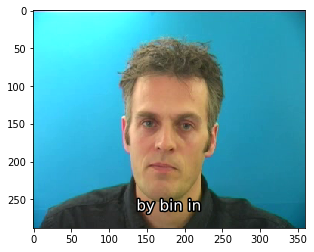

In [26]:
np.random.seed(100)
CURRENT_PATH = "/content/drive/My Drive/GRID/images/mtcnn/final_output"
PREDICT_GREEDY      = False
PREDICT_BEAM_WIDTH  = 200
PREDICT_DICTIONARY  = '/content/drive/My Drive/GRID/images/mtcnn/grid.txt'
videopath='/content/drive/My Drive/GRID/s2_samples/bbaf1n.mpg'
weightpath='/content/drive/My Drive/GRID/images/mtcnn/final_output/2019:11:29:15:57:44/weights79.h5'
framepath='/content/drive/My Drive/GRID/images/mtcnn/s2/bbaf1n'

def predict(weight_path, video_path, absolute_max_string_len=32, output_size=28):
    video = Video(vtype='face')
    if os.path.isfile(video_path):
        video.from_video(video_path)
    else:
        video.from_frames(video_path)
    if K.image_data_format() == 'channels_first':
        img_c, frames_n, img_w, img_h = video.data.shape
    else:
        frames_n, img_w, img_h, img_c = video.data.shape
    lipnet = LipNet(img_c=img_c, img_w=img_w, img_h=img_h, frames_n=frames_n,
                    absolute_max_string_len=absolute_max_string_len, output_size=output_size)

    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    lipnet.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)
    lipnet.model.load_weights(weight_path)

    spell = Spellings(path=PREDICT_DICTIONARY)
    decoder = Decoder(greedy=PREDICT_GREEDY, beam_width=PREDICT_BEAM_WIDTH,
                      postprocessors=[labels_to_text, spell.sentence])
    X_data       = np.array([video.data]).astype(np.float32) / 255
    input_length = np.array([len(video.data)])
    y_pred         = lipnet.predict(X_data)
    restvalbefore=decoder.decode(y_pred, input_length)
    result         = restvalbefore[0]
    return video, result

video, result = predict(weightpath,videopath)
if video is not None:
  show_video_subtitle(video.face, result)